In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
project_id = 'gad-playground-212407'

## Fetch data 

We start by fetching ~30K records from the original dataset:

In [3]:
sql = """SELECT 
              unique_key
            , taxi_id
            , trip_start_timestamp
            , trip_end_timestamp
            , trip_seconds
            , trip_miles
            , pickup_census_tract
            , dropoff_census_tract
            , pickup_community_area
            , dropoff_community_area
            , pickup_latitude
            , pickup_longitude
            , dropoff_latitude
            , dropoff_longitude
            , payment_type
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips` 
WHERE RAND() < (30000/112860054) 
AND  trip_start_timestamp < '2016-01-01' """
df = pd.read_gbq(sql, project_id=project_id, dialect='standard')

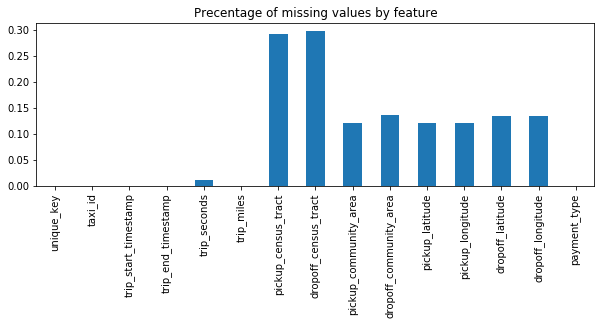

In [12]:
# Plotting missing values rate
(df.isnull().sum()/(30000)).plot(kind='bar', figsize=(10,3))
plt.title('Precentage of missing values by feature')
plt.show()

Our first obsercation that many pickup and dropoff locations are missing, <br> 
since our goal is to predict trip duraion we have to know the origin and destination of the trip. <br>
For this reason, when building the dataset we will filter missing destination and origin rows

In [14]:
df = df.dropna()

In [17]:
df[['trip_start_timestamp', 'trip_end_timestamp', 'trip_seconds']].head()

,trip_start_timestamp,trip_end_timestamp
9,2015-09-23 08:00:00+00:00,2015-09-23 08:15:00+00:00
10,2013-12-20 11:15:00+00:00,2013-12-20 11:30:00+00:00
11,2015-07-21 09:45:00+00:00,2015-07-21 10:00:00+00:00
12,2015-09-10 13:45:00+00:00,2015-09-10 14:00:00+00:00
13,2015-02-27 07:30:00+00:00,2015-02-27 07:30:00+00:00


We note that the trip start and end time are rounded to 15 minutes <br>
However trip_seconds is not round, so it probably reflects a more accurate measurement of the ride time

## Analyzing features distributions

In [19]:
df['trip_start_timestamp'] = df['trip_start_timestamp'].apply(pd.Timestamp)
df['trip_end_timestamp'] = df['trip_end_timestamp'].apply(pd.Timestamp)

Trip trends over the years:

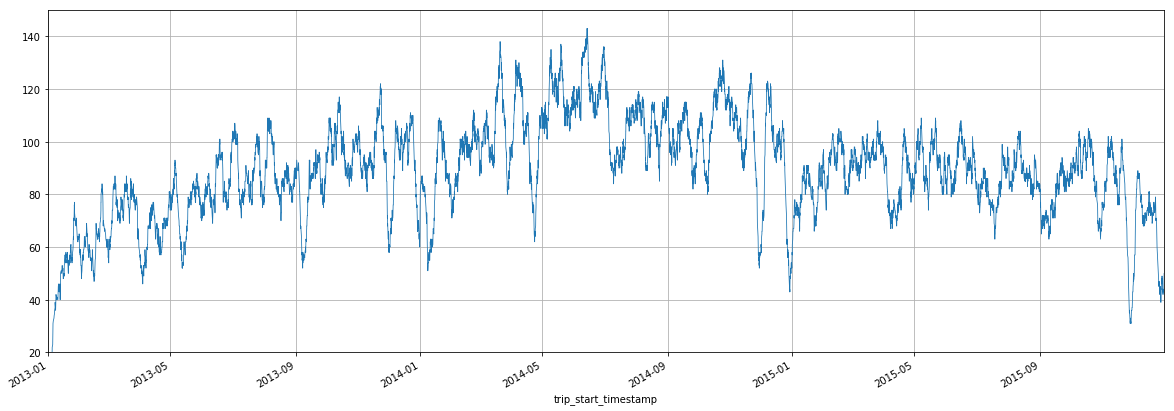

In [21]:
total_trips = df.set_index('trip_start_timestamp').sort_index()['trip_miles'].fillna(0).rolling('7d').count()
total_trips.plot(lw=0.8, figsize=(20,7))
plt.ylim(20,)
plt.grid()
plt.show()

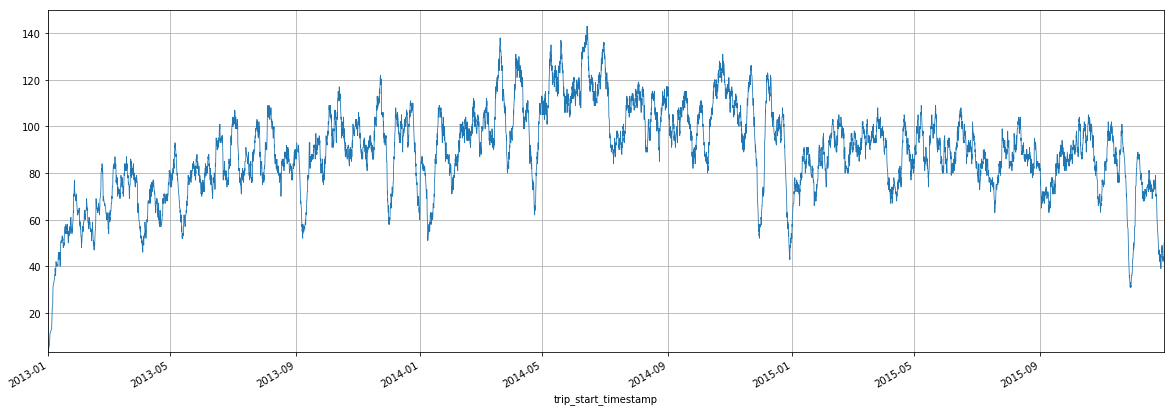

In [22]:
df['trip_speed_kmph'] = (df['trip_miles'] * (1.60934)) / ((df['trip_seconds'] + .01)/ (60 * 60))

trip_speed = df.set_index('trip_start_timestamp').sort_index()['trip_speed_kmph'].fillna(0).rolling('7d').median()
total_trips.plot(lw=0.8, figsize=(20,7))
plt.ylim(3,)
plt.grid()
plt.show()

There doesn't seem to be a clear trend to the total number of rides or to the travel speed

## Filtering out unreasonable trip speeds

In [23]:
# Impute data
df = df[df['trip_miles'] > 0.2] # Filter very short trips
df = df[df['trip_seconds'] > 2] # Filter very short trips
df = df[df['trip_speed_kmph'].between(5,120)] # Filter very FAST and very SLOW trips

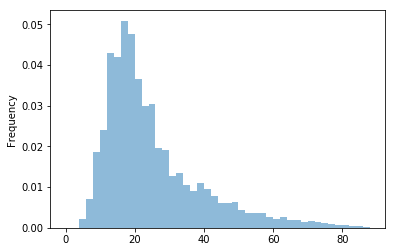

In [13]:
df['trip_speed_kmph'].dropna().plot(kind='hist', bins=range(0,90, 2), alpha=0.5, density=True)
plt.show()

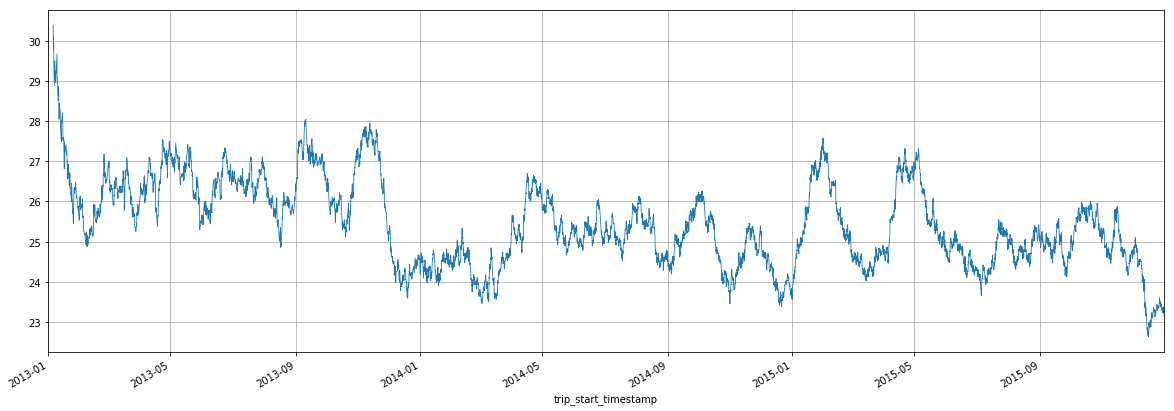

In [18]:
total_trips = df.set_index('trip_start_timestamp').sort_index()['trip_speed_kmph'].fillna(0).rolling('30d', min_periods=30).mean()
total_trips.plot(lw=0.8, figsize=(20,7))
plt.grid()
plt.show()

## Exemine the effect of the trip date and time on the trip duration

In [24]:
df['hour_of_day'] = df['trip_start_timestamp'].dt.hour
df['day_of_week'] = df['trip_start_timestamp'].dt.weekday

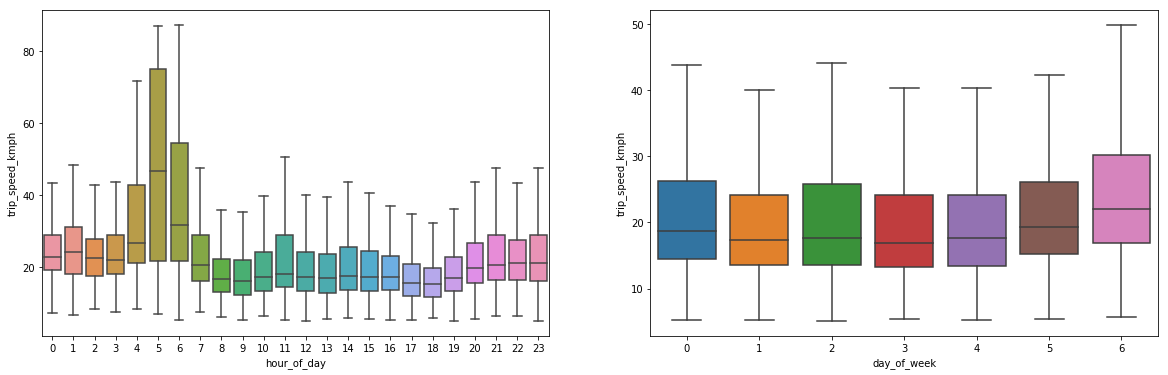

In [28]:
fig = plt.figure(figsize=(20,6))
plt.subplot(1, 2, 1)
sns.boxplot(x='hour_of_day', y='trip_speed_kmph', data=df, showfliers=False)
plt.subplot(1, 2, 2)
sns.boxplot(x='day_of_week', y='trip_speed_kmph', data=df, showfliers=False)
plt.show()

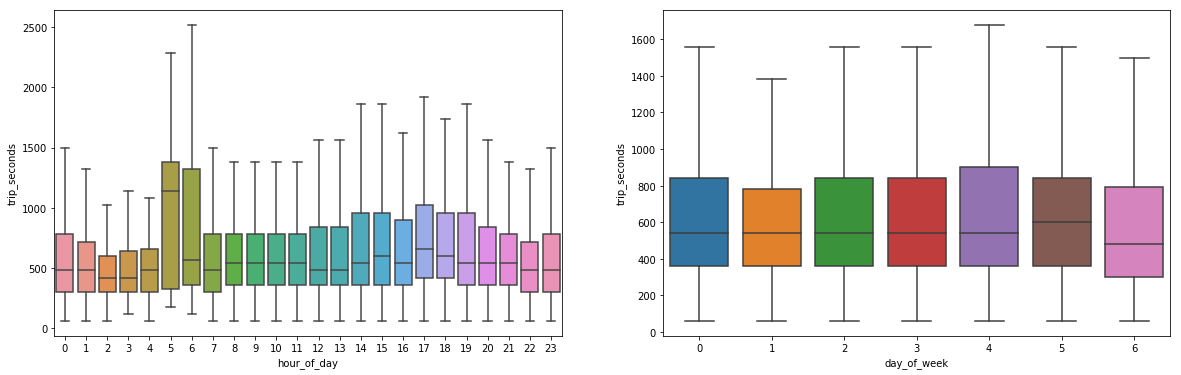

In [29]:
fig = plt.figure(figsize=(20,6))
plt.subplot(1, 2, 1)
sns.boxplot(x='hour_of_day', y='trip_seconds', data=df, showfliers=False)
plt.subplot(1, 2, 2)
sns.boxplot(x='day_of_week', y='trip_seconds', data=df, showfliers=False)
plt.show()